In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

torch.cuda.manual_seed_all(4200)
np.random.seed(133700)

This notebook outlines an approach for subsurface salt identification from images generated with reflection seismology. The dataset is from this Kaggle challenge: [TGS Salt Identification](https://www.kaggle.com/c/tgs-salt-identification-challenge/).


# Explore Images

 We also load in a csv which contains information about the depths each image was taken at and a csv which lists on training images along with a run-length encoding of the mask.

In [2]:
depths = pd.read_csv("SaltID/depths.csv", index_col=[0])
depths.head()

,z
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305
5b435fad9d,503
e340e7bfca,783


In [3]:
train_df = pd.read_csv("SaltID/train.csv", index_col=[0])
train_df.fillna('', inplace=True)
train_df = pd.concat([train_df, depths], axis=1, join='inner')
train_df.head()

,rle_mask,z
id,,
575d24d81d,,843
a266a2a9df,5051 5151,794
75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797


We can get a distribution of the depths our images were taken at.

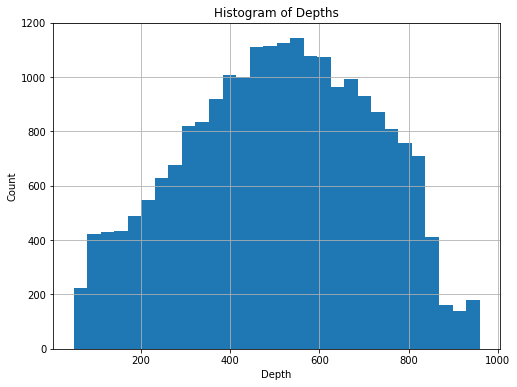

In [4]:
depths.hist(figsize=(8, 6), bins=30);
plt.xlabel("Depth");
plt.ylabel("Count");
plt.title("Histogram of Depths");

We can see that a large bulk of our depths are between 300 and 800 but there are some depths at the more extremes of below 200 and above 900. This suggests we should take some care when creating our validation set to not overrepresent depths at the extremes.

We now look at what our model's focus is: our images and masks. We show both some images and masks on their own, as well as overlayed with each other to show the interplay. We then look a bit more closely at the overall salt-to-sediment ratios of our images, as we'll see there's a wide variance in the amount of an image covered in salt.

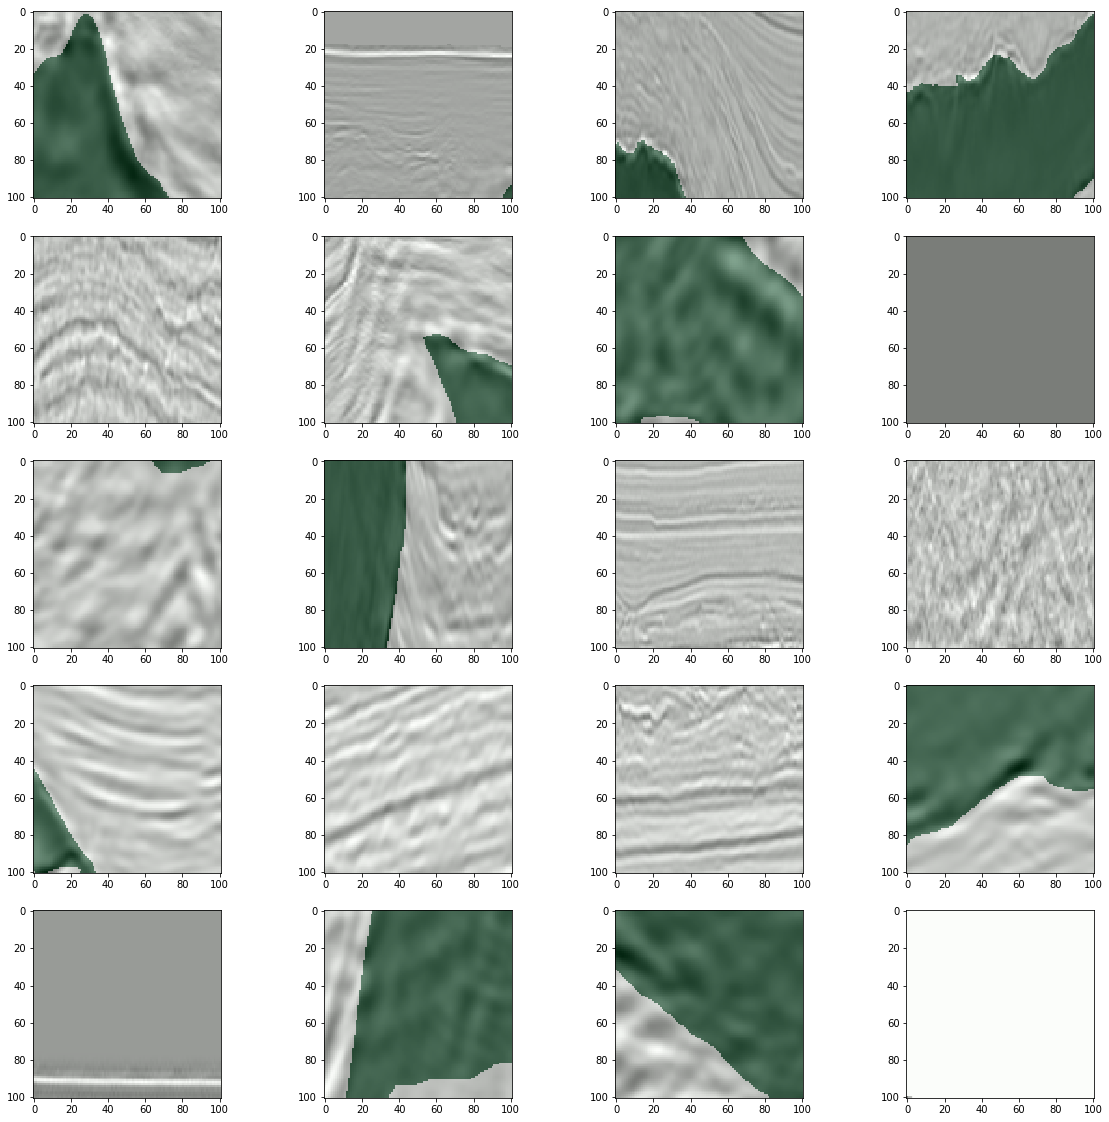

In [5]:
sample_images = train_df.sample(20, random_state=42).index

fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs_f = axs.flatten()
for i, image in enumerate(sample_images):
    img = imread('SaltID/train/images/' + image + '.png')
    mask = imread('SaltID/train/masks/' + image + '.png') 
    
    ax = axs_f[i]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.5, cmap="Greens")

We note two things, there's a wide variance in the proportion of the salt the covers the images and there are some training images which don't look that helpful, like in the bottom right or bottom left corner. We'll first focus on those images which look like bad training data.

In [6]:
# Our desired image size.
path_train = 'SaltID/train/'
path_test = 'SaltID/test/'

train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [7]:
train_df['img'] = None
train_df['mask'] = None

for id_ in train_ids:
    img_id = id_.split('.')[0]
    img = imread(path_train + 'images/' + id_)
    mask = imread(path_train + 'masks/' + id_)
    train_df.at[img_id, 'img'] = img.astype(np.uint8)
    train_df.at[img_id, 'mask'] = mask.astype(bool)

In [8]:
low_var_ids = []
for idx, row in train_df.iterrows():
    if np.var(row['img']) == 0:
        low_var_ids.append(idx)
print(len(low_var_ids))

80


Thus we find 80 images with zero variance in pixel values, i.e. they are all a solid sheet of color. We expect these to be errorneous in the training data. For completeness, we'll train our model with them included as well as excluded and look for any difference.

Now we look at the salt coverage of images.

In [9]:
for idx, row in train_df.iterrows():
    m = train_df.at[idx, 'mask']
    cov = m.sum() / (m.shape[0] * m.shape[1])
    train_df.at[idx, 'cov_prop'] = cov
    train_df.at[idx, 'cov_class'] = 0 if cov == 0 else np.floor(cov*10 + 1)

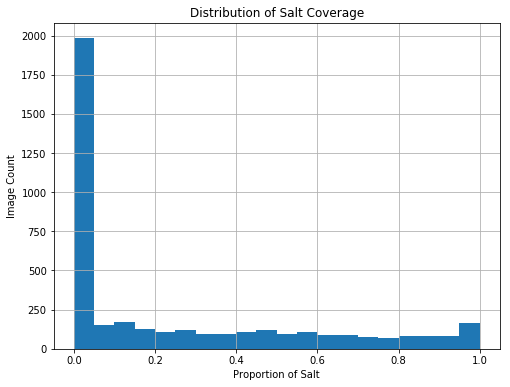

In [10]:
# https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification
train_df['cov_prop'].hist(figsize=(8, 6), bins=20)
plt.xlabel("Proportion of Salt")
plt.ylabel("Image Count")
plt.title("Distribution of Salt Coverage");

We note that most of the images have very little salt, but that also there are images all across the spectrum. We need to take care to represent these proportions in our training vs validation data faithfully.

Finally, we take a closer look at some of our masks. In particular, there's some weird ones here too, as we noticed with the training data. There appear to be masks which don't confirm to any expected shape and are instead regular rectangles. 

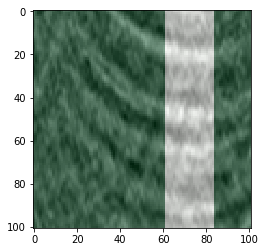

In [11]:
imgtest = 'e6e3e58c43'

img = imread('SaltID/train/images/' + imgtest + '.png')
mask = imread('SaltID/train/masks/' + imgtest + '.png') 

plt.imshow(img, cmap="Greys")
plt.imshow(mask, alpha=0.5, cmap="Greens");

These can be algorithmically found as follows. We will attempt to build the model both with and without these as with the single color training images.

In [12]:
# https://www.kaggle.com/pestipeti/fake-incorrect-training-masks
train_df['simple_mask'] = False
for index, row in train_df.iterrows():
    encoded_mask = row['rle_mask'].split(' ')
    if len(encoded_mask) > 1 and len(encoded_mask) < 5 and \
    int(encoded_mask[1]) % 101 == 0 and \
    encoded_mask[1] != 101*101:
        train_df.loc[index,'simple_mask'] = True
susp_masks = train_df[(train_df['simple_mask'] == True)].index.values
print(len(susp_masks))

116


# Preparing for Model

We now prepare our data for analysis. We first resize the images to be easier to use with our chosen U-Net architecture and then have to prepare the imges for use with Pytorch, our chosen neural network library. 

In [13]:
# Our desired image size.
im_width = 128
im_height = 128
im_chan = 1

#  https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics
# Get and resize train images and masks
train_df['img_resize'] = None
train_df['mask_resize'] = None
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    df_id = id_.split('.')[0]
    img = imread(path_train + 'images/' + id_)
    x = resize(img, (im_width, im_height, im_chan), 
                        mode='constant',
                        preserve_range=True).astype(np.uint8)
    train_df.at[df_id, 'img_resize'] = x    
    mask = imread(path_train + 'masks/' + id_)
    y =  resize(mask, (128, 128, 1), 
                mode='constant', 
                anti_aliasing=True,
                preserve_range=True).astype(np.bool_)
    train_df.at[df_id, 'mask_resize'] = y

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


We verify that the images were preserved through the resizing. 

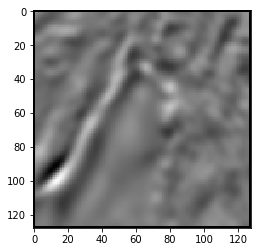

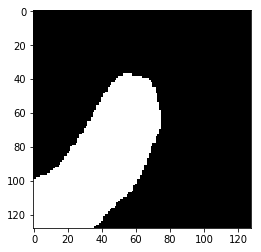

In [14]:
# Verify the resizing looks correct.
ix = random.randint(0, len(train_df))
plt.imshow(np.dstack((train_df.iloc[ix]['img_resize'],
                      train_df.iloc[ix]['img_resize'],
                      train_df.iloc[ix]['img_resize'],)))
plt.show()
tmp = np.squeeze(train_df.iloc[ix]['mask_resize']).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

Next, we create a class that is used by Pytorch to load images for the model during training. This requires implementing a class with some basic methods which define how to grab items from the dataset.

In [15]:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader
class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,
                 train=True, 
                 preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

We then shape the data in the correct way for Pytorch: 

`(batch_size, channels, height, width)`. 

In [16]:
train_df['img_resize'] = train_df['img_resize'] \
                        .apply(lambda x: (x.reshape(1, 128, 128)/255) \
                                          .astype(np.float32))
train_df['mask_resize'] = train_df['mask_resize'] \
                        .apply(lambda x: x.reshape(1, 128, 128) \
                                          .astype(np.float32))

We then split our data into training and validations sets. We create different DFs, omitting each of the previously mentioned classes of images that had suspicious masks or were all one color.

In [17]:
train_df_all = train_df.copy()
# Create df omitting those that were one color.
train_df_oc = train_df.drop(low_var_ids)
# Create df omitting those that had suspicious masks.
train_df_susp = train_df.drop(susp_masks)
# Create df that removes suspicious masks and one color images.
train_df_rem = train_df.drop(low_var_ids).drop(susp_masks)

In [18]:
def ttsplit(df):
    return train_test_split(
        df.index.values,
        df['cov_prop'].values,
        df['z'].values,
        test_size=0.2, 
        stratify=df['cov_class'], 
        random_state=42)

ids_t_all, ids_v_all, cov_t_all, cov_v_all, depth_t_all, depth_v_all = \
    ttsplit(train_df_all)

ids_t_oc, ids_v_oc, cov_t_oc, cov_v_oc, depth_t_oc, depth_v_oc = \
    ttsplit(train_df_oc)

ids_t_susp, ids_v_susp, cov_t_susp, cov_v_susp, depth_t_susp, depth_v_susp = \
    ttsplit(train_df_susp)

ids_t_rem, ids_v_rem, cov_t_rem, cov_v_rem, depth_t_rem, depth_v_rem = \
    ttsplit(train_df_rem)

As we can see below, we've successfully made train and validation sets with similar distributions of coverage and depth.

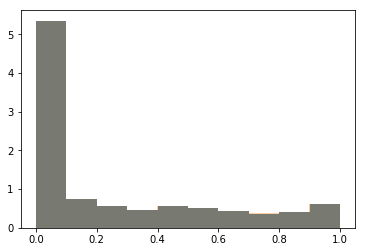

In [19]:
plt.hist(cov_t_all, density=True)
plt.hist(cov_v_all, density=True, alpha=0.4);

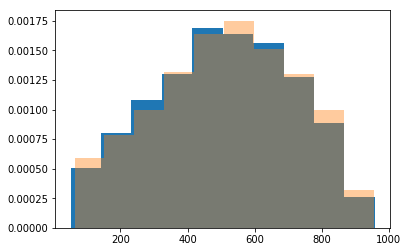

In [20]:
plt.hist(depth_t_all, density=True)
plt.hist(depth_v_all, density=True, alpha=0.4);

Finally, we create class instances to use with our Pytorch model.

In [36]:
batch_size = 16

def create_dataloader(df, idxs):
    df_slice = df.loc[idxs]
    dataset =  saltIDDataset(df_slice['img_resize'].values, 
                             train=True, 
                             preprocessed_masks=df_slice['mask_resize'].values)
    loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
    
    return dataset, loader

def create_dataloaders(df, train_idxs, val_idxs):
    train_dataset, train_loader = create_dataloader(df, train_idxs)
    val_dataset, val_loader = create_dataloader(df, val_idxs)
    return train_dataset, val_dataset, train_loader, val_loader

In [37]:
all_train, all_val, all_train_l, all_val_l = \
        create_dataloaders(train_df_all, ids_t_all, ids_v_all)

oc_train, oc_val, oc_train_l, oc_val_l = \
        create_dataloaders(train_df_oc, ids_t_oc, ids_v_oc)

susp_train, susp_val, susp_train_l, susp_val_l = \
        create_dataloaders(train_df_susp, ids_t_susp, ids_v_susp)

rem_train, rem_val, rem_train_l, rem_val_l = \
        create_dataloaders(train_df_rem, ids_t_rem, ids_v_rem)

# Define U-Net Model

Here's the meat of the kernel, where we define our U-Net architecture. See also this excellent kernel from an older challenge: https://www.kaggle.com/mlagunas/naive-unet-with-pytorch-tensorboard-logging.

In [38]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
start_fm = 16

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(1, start_fm, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
        #self.final_act = nn.Sigmoid()
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        
        one_by_one = self.one_by_one(ex_conv1)
        
        return one_by_one

We define a BCEWithLogitsLoss since we're comparing pixel by pixel. In addition, we didn't include a final sigmoid activation as this loss function includes a sigmoid for us.

In [39]:
model = Unet()
model.cuda();

criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [50]:
def train_model(train_loader, val_loader, epochs=20):
    model = Unet()
    model.cuda();

    criterion = nn.BCEWithLogitsLoss()

    learning_rate = 1e-3

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    mean_train_losses = []
    mean_val_losses = []
    for epoch in range(epochs):
        train_losses = []
        val_losses = []
        for images, masks in train_loader:   
            images = Variable(images.cuda())
            masks = Variable(masks.cuda())

            outputs = model(images)        

            loss = criterion(outputs, masks)
            train_losses.append(loss.data.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        for images, masks in val_loader:
            images = Variable(images.cuda())
            masks = Variable(masks.cuda())

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_losses.append(loss.data.item())

        mean_train_losses.append(np.mean(train_losses))
        mean_val_losses.append(np.mean(val_losses))
        # Print Loss
        print('Epoch: {}. Train Loss: {}. Val Loss: {}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))
        
    return model, mean_train_losses, mean_val_losses

In [51]:
all_model, all_t_loss, all_val_loss = train_model(all_train_l, all_val_l)

Epoch: 1. Train Loss: 0.5007157614827156. Val Loss: 0.381408776640892
Epoch: 2. Train Loss: 0.33587557084858416. Val Loss: 0.30742338716983797
Epoch: 3. Train Loss: 0.2978868563473225. Val Loss: 0.2942816314101219
Epoch: 4. Train Loss: 0.2688836481422186. Val Loss: 0.2994832494854927
Epoch: 5. Train Loss: 0.25902434803545477. Val Loss: 0.2638885444402695
Epoch: 6. Train Loss: 0.2410111291706562. Val Loss: 0.2549550147354603
Epoch: 7. Train Loss: 0.22811339043080806. Val Loss: 0.22727050945162774
Epoch: 8. Train Loss: 0.20881798967719079. Val Loss: 0.2243259407579899
Epoch: 9. Train Loss: 0.20554630864411594. Val Loss: 0.2225170236825943
Epoch: 10. Train Loss: 0.19535331152379512. Val Loss: 0.2157321873307228
Epoch: 11. Train Loss: 0.1872780268639326. Val Loss: 0.20594774097204208
Epoch: 12. Train Loss: 0.18096915408968925. Val Loss: 0.19364202901721
Epoch: 13. Train Loss: 0.18374241668730973. Val Loss: 0.21314728319644927
Epoch: 14. Train Loss: 0.16608802001923323. Val Loss: 0.19024190

In [52]:
oc_model, oc_t_loss, oc_val_loss = train_model(oc_train_l, oc_val_l)

Epoch: 1. Train Loss: 0.4982801330636959. Val Loss: 0.3956966752908668
Epoch: 2. Train Loss: 0.3493460431238826. Val Loss: 0.302307945124957
Epoch: 3. Train Loss: 0.29501957073807716. Val Loss: 0.2647901159159991
Epoch: 4. Train Loss: 0.2732775356164392. Val Loss: 0.24956989197098478
Epoch: 5. Train Loss: 0.26219032362711675. Val Loss: 0.2747825934570663
Epoch: 6. Train Loss: 0.25151654218836705. Val Loss: 0.2181842208516841
Epoch: 7. Train Loss: 0.2253174359092907. Val Loss: 0.24267790816268142
Epoch: 8. Train Loss: 0.2346895432137713. Val Loss: 0.21182730429026544
Epoch: 9. Train Loss: 0.2079949496427969. Val Loss: 0.21147375781925357
Epoch: 10. Train Loss: 0.20180386407490897. Val Loss: 0.19706669388985149
Epoch: 11. Train Loss: 0.19445322028228215. Val Loss: 0.18034617222693503
Epoch: 12. Train Loss: 0.18838103115558624. Val Loss: 0.192976607351887
Epoch: 13. Train Loss: 0.1757315275620441. Val Loss: 0.21211279457320972
Epoch: 14. Train Loss: 0.17817859188178364. Val Loss: 0.186535

In [53]:
susp_model, susp_t_loss, susp_val_loss = train_model(susp_train_l, susp_val_l)

Epoch: 1. Train Loss: 0.5374552798576844. Val Loss: 0.38781577470351236
Epoch: 2. Train Loss: 0.3401326378950706. Val Loss: 0.2933823134826154
Epoch: 3. Train Loss: 0.28642665300613795. Val Loss: 0.2523451681647982
Epoch: 4. Train Loss: 0.24705174966500357. Val Loss: 0.26324439413693485
Epoch: 5. Train Loss: 0.23052060669049237. Val Loss: 0.22023170699878614
Epoch: 6. Train Loss: 0.21769818732371696. Val Loss: 0.21190876787414356
Epoch: 7. Train Loss: 0.20518574424279043. Val Loss: 0.20734937184927416
Epoch: 8. Train Loss: 0.18429237672915824. Val Loss: 0.18975394051902147
Epoch: 9. Train Loss: 0.1735271668778016. Val Loss: 0.2004262333621784
Epoch: 10. Train Loss: 0.175432838117465. Val Loss: 0.19202482365832038
Epoch: 11. Train Loss: 0.16997271300508426. Val Loss: 0.18850996725413263
Epoch: 12. Train Loss: 0.14315356264511744. Val Loss: 0.16925495528444953
Epoch: 13. Train Loss: 0.15666135551455693. Val Loss: 0.19102152224097932
Epoch: 14. Train Loss: 0.14276514815596433. Val Loss: 0

In [54]:
rem_model, rem_t_loss, rem_val_loss = train_model(rem_train_l, rem_val_l)

Epoch: 1. Train Loss: 0.4524948044597166. Val Loss: 0.3309917204702894
Epoch: 2. Train Loss: 0.29665323280539185. Val Loss: 0.2818934414535761
Epoch: 3. Train Loss: 0.2697255650427953. Val Loss: 0.25602322289099294
Epoch: 4. Train Loss: 0.2315437561632451. Val Loss: 0.22920856749018034
Epoch: 5. Train Loss: 0.22463291399766014. Val Loss: 0.2653301232494414
Epoch: 6. Train Loss: 0.2213646304544978. Val Loss: 0.21557639135668674
Epoch: 7. Train Loss: 0.19664509980622386. Val Loss: 0.18905612003679076
Epoch: 8. Train Loss: 0.1822555740388276. Val Loss: 0.19444015808403492
Epoch: 9. Train Loss: 0.17388660893702382. Val Loss: 0.1821745427635809
Epoch: 10. Train Loss: 0.17436132823843606. Val Loss: 0.2153249092710515
Epoch: 11. Train Loss: 0.1689887157597467. Val Loss: 0.16586520724619427
Epoch: 12. Train Loss: 0.1525360007833748. Val Loss: 0.15373266069218516
Epoch: 13. Train Loss: 0.15448552325211895. Val Loss: 0.16838037168296674
Epoch: 14. Train Loss: 0.13749478795414508. Val Loss: 0.170

In [55]:
def plot_loss(mean_train_losses, mean_val_losses):
    train_loss_series = pd.Series(mean_train_losses)
    val_loss_series = pd.Series(mean_val_losses)
    train_loss_series.plot(label="train")
    val_loss_series.plot(label="validation")
    plt.legend();

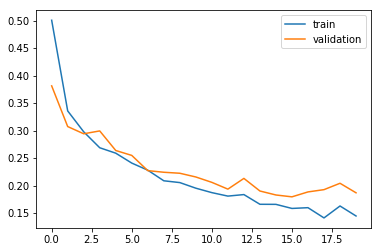

In [57]:
plot_loss(all_t_loss, all_val_loss)

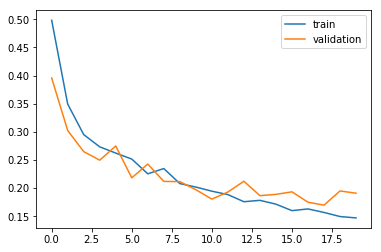

In [58]:
plot_loss(oc_t_loss, oc_val_loss)

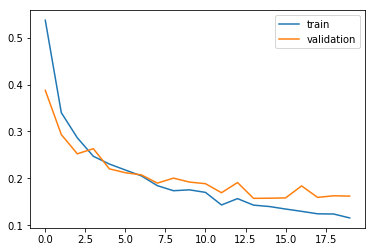

In [59]:
plot_loss(susp_t_loss, susp_val_loss)

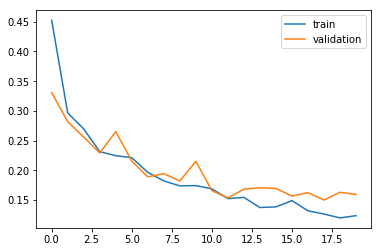

In [56]:
plot_loss(rem_t_loss, rem_val_loss)

Finally we compute our IOU score for various thresholds. 

In [60]:
def compute_IOU(model, val_loader):
    y_pred_true_pairs = []
    for images, masks in val_loader:
        images = Variable(images.cuda())
        y_preds = model(images)
        for i, _ in enumerate(images):
            y_pred = y_preds[i] 
            y_pred = torch.sigmoid(y_pred)
            y_pred = y_pred.cpu().data.numpy()
            y_pred_true_pairs.append((y_pred, masks[i]))    

    # https://www.kaggle.com/leighplt/goto-pytorch-fix-for-v0-3
    thres_tuples = []
    for threshold in np.linspace(0, 1, 11):

        ious = []
        for y_pred, mask in y_pred_true_pairs:
            prediction = (y_pred > threshold).astype(int)
            iou = jaccard_similarity_score(mask.flatten(), prediction.flatten())
            ious.append(iou)

        accuracies = [np.mean(ious > iou_threshold)
                     for iou_threshold in np.linspace(0.5, 0.95, 10)]
        thres_tuples.append((threshold, np.mean(accuracies)))
        print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))

    return thres_tuples

In [61]:
compute_IOU(all_model, all_val_l)

Threshold: 0.0, Metric: 0.136
Threshold: 0.1, Metric: 0.841
Threshold: 0.2, Metric: 0.883
Threshold: 0.3, Metric: 0.894
Threshold: 0.4, Metric: 0.895
Threshold: 0.5, Metric: 0.892
Threshold: 0.6, Metric: 0.889
Threshold: 0.7, Metric: 0.884
Threshold: 0.8, Metric: 0.870
Threshold: 0.9, Metric: 0.840
Threshold: 1.0, Metric: 0.635


[(0.0, 0.1355),
 (0.1, 0.8407500000000001),
 (0.2, 0.882625),
 (0.30000000000000004, 0.8938750000000001),
 (0.4, 0.8946250000000001),
 (0.5, 0.891875),
 (0.6000000000000001, 0.8891249999999999),
 (0.7000000000000001, 0.8840000000000001),
 (0.8, 0.8696249999999999),
 (0.9, 0.8399999999999999),
 (1.0, 0.635375)]

In [62]:
compute_IOU(oc_model, oc_val_l)

Threshold: 0.0, Metric: 0.139
Threshold: 0.1, Metric: 0.808
Threshold: 0.2, Metric: 0.876
Threshold: 0.3, Metric: 0.899
Threshold: 0.4, Metric: 0.907
Threshold: 0.5, Metric: 0.906
Threshold: 0.6, Metric: 0.903
Threshold: 0.7, Metric: 0.893
Threshold: 0.8, Metric: 0.874
Threshold: 0.9, Metric: 0.840
Threshold: 1.0, Metric: 0.628


[(0.0, 0.13877551020408163),
 (0.1, 0.8082908163265307),
 (0.2, 0.8755102040816325),
 (0.30000000000000004, 0.8994897959183674),
 (0.4, 0.9068877551020409),
 (0.5, 0.9063775510204082),
 (0.6000000000000001, 0.9029336734693878),
 (0.7000000000000001, 0.892984693877551),
 (0.8, 0.874234693877551),
 (0.9, 0.8404336734693878),
 (1.0, 0.6283163265306123)]

In [63]:
compute_IOU(susp_model, susp_val_l)

Threshold: 0.0, Metric: 0.129
Threshold: 0.1, Metric: 0.909
Threshold: 0.2, Metric: 0.922
Threshold: 0.3, Metric: 0.928
Threshold: 0.4, Metric: 0.932
Threshold: 0.5, Metric: 0.934
Threshold: 0.6, Metric: 0.933
Threshold: 0.7, Metric: 0.932
Threshold: 0.8, Metric: 0.926
Threshold: 0.9, Metric: 0.902
Threshold: 1.0, Metric: 0.651


[(0.0, 0.12921492921492922),
 (0.1, 0.9087516087516088),
 (0.2, 0.9218790218790218),
 (0.30000000000000004, 0.9279279279279278),
 (0.4, 0.9316602316602317),
 (0.5, 0.9337194337194339),
 (0.6000000000000001, 0.9332046332046332),
 (0.7000000000000001, 0.931788931788932),
 (0.8, 0.9258687258687258),
 (0.9, 0.9020592020592021),
 (1.0, 0.6512226512226512)]

In [64]:
compute_IOU(rem_model, rem_val_l)

Threshold: 0.0, Metric: 0.131
Threshold: 0.1, Metric: 0.897
Threshold: 0.2, Metric: 0.922
Threshold: 0.3, Metric: 0.932
Threshold: 0.4, Metric: 0.933
Threshold: 0.5, Metric: 0.930
Threshold: 0.6, Metric: 0.928
Threshold: 0.7, Metric: 0.923
Threshold: 0.8, Metric: 0.910
Threshold: 0.9, Metric: 0.877
Threshold: 1.0, Metric: 0.644


[(0.0, 0.13088042049934298),
 (0.1, 0.8973718791064389),
 (0.2, 0.9224704336399474),
 (0.30000000000000004, 0.9315374507227332),
 (0.4, 0.9331143232588699),
 (0.5, 0.9303547963206308),
 (0.6000000000000001, 0.9279894875164258),
 (0.7000000000000001, 0.9229960578186599),
 (0.8, 0.9098554533508543),
 (0.9, 0.8773981603153744),
 (1.0, 0.6444152431011826)]

# Product Implementation

This model's primary use is in energy and infrastructure projects that involve the ocean floor. Salt has different characteristics which can make some projects unsafe or unstable. Currently, analysis of these images is time consuming and costly, as it requires expert review. This model offers a way to expedite the process, saving time, money and ensuring the safety of the workers who are part of the projects.

In production, this model could be deployed on a cloud service like AWS and any new reflective seismology images can be passed through to flag potential salt deposits. It can process a single image very quickly and thus it can easily fit into any current workflow prior to expert review. And additionally as new images are acquired, the model's accuray can continue to grow as we have an ever increasing repository of images with expert verification. 

# Appendix: Additional Test Images

1432.3904309190582
de95e861ac


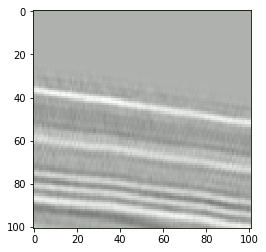

In [96]:
imgtest = '9128b824e5'

img = imread('SaltID/train/images/' + imgtest + '.png')
mask = imread('SaltID/train/masks/' + imgtest + '.png') 

plt.imshow(img, cmap="Greys")
plt.imshow(mask, alpha=0.5, cmap="Greens")

0.0
de95e861ac
z    199
Name: b552fb0d9d, dtype: int64


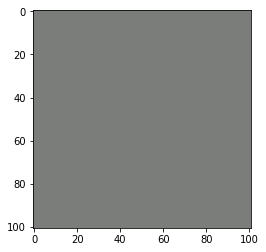

In [98]:
imgtest = 'b552fb0d9d'

img = imread('SaltID/train/images/' + imgtest + '.png')
mask = imread('SaltID/train/masks/' + imgtest + '.png') 

plt.imshow(img, cmap="Greys")
plt.imshow(mask, alpha=0.5, cmap="Greens")